In [119]:
import pandas as pd
import numpy as np
import preprocessor
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import importlib

In [120]:
%matplotlib inline

In [121]:
prediction_variable = "int_rate"

# need to include int_rate, installment here since it is determined by the loan grade, which we are trying to predict
extraneous_cols = ["out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries",
				   "collection_recovery_fee", "next_pymnt_d", "last_pymnt_d", "last_pymnt_amnt", "last_credit_pull_d", "acc_now_delinq",
				   "sub_grade", "issue_d", "initial_list_status", "loan_amnt", "funded_amnt_inv", "emp_title", "pymnt_plan", "zip_code", "title",
                   "addr_state", "earliest_cr_line", "loan_status", "hardship_flag", "application_type", "grade", "installment"]

important_cols = ["annual_inc", "verification_status", "term", "home_ownership", "emp_length",
				  "funded_amnt"] #add back delinq_2yrs, dti, inq_last_6mths

In [122]:
importlib.reload(preprocessor)

lc = preprocessor.loadData([#"data/LC_2007_2011_loan_data.csv",
							#"data/LC_2012_2013_loan_data.csv",
							"data/LC_2014_loan_data.csv",
                            "data/LC_2015_loan_data.csv",
                            "data/LC_2016q1_loan_data.csv",
                            "data/LC_2016q2_loan_data.csv"], extraneous_cols)

In [123]:
lc.reset_index(drop = True, inplace = True)
lc = preprocessor.dropExtraCols(lc, important_cols)
lc = preprocessor.replacements(lc)
lc = preprocessor.fillnas(lc)

In [124]:
#create dummy variables for categorical variables
lc = pd.get_dummies(lc, columns=["home_ownership", "verification_status", "purpose"])

In [134]:
lc = lc.loc[lc["term"] == 36]

In [135]:
print("Dimensions: ", lc.shape)
lc.head(5)

Dimensions:  (616400, 74)


,int_rate,funded_amnt,term,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,6.99,10400.0,36,8,58000.0,14.92,0.0,2.0,42.0,17.0,...,0,0,0,0,0,0,0,0,0,0
4,13.66,9600.0,36,10,69000.0,25.81,0.0,0.0,30.0,12.0,...,0,0,0,0,0,0,0,0,0,0
5,13.66,7650.0,36,0,50000.0,34.81,0.0,1.0,30.0,11.0,...,0,0,0,0,0,0,0,0,0,0
6,11.99,2500.0,36,0,89000.0,13.77,0.0,1.0,55.0,9.0,...,1,0,0,0,0,0,0,0,0,0
9,14.31,23325.0,36,10,72000.0,27.03,1.0,0.0,1.0,14.0,...,0,0,0,0,0,0,0,0,0,0


In [136]:
#reorder columns so variable being predicted is in first column
cols = lc.columns.tolist()
cols.insert(0, cols.pop(cols.index(prediction_variable)))
lc = lc.loc[:, cols]

In [137]:
data = lc.values
X = data[:, 1:]
y = data[:, 0]

In [138]:
#le = LabelEncoder()
#le.fit(y)
#y_encoded = le.transform(y)

#use fit_transform in the future to just modify y directly

In [139]:
#rf = RandomForestClassifier(n_estimators=100)
#skf = StratifiedKFold(n_splits = 5, shuffle = True)
#print("Cross-validation scores:\n{}".format(cross_val_score(rf, X, y_encoded, cv=skf, n_jobs=-1)))

In [140]:
#for col in lc.columns:
#    if "Aug-2017" in lc[col].values:
#        print(col)

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)
rf_tt = RandomForestRegressor(n_estimators = 100, n_jobs = -1)
rf_tt.fit(X_train, y_train)
print("Training accuracy: {:.2f}".format(rf_tt.score(X_train, y_train)))
print("Generalization accuracy: {:.2f}".format(rf_tt.score(X_test, y_test)))

Generalization accuracy: 0.52


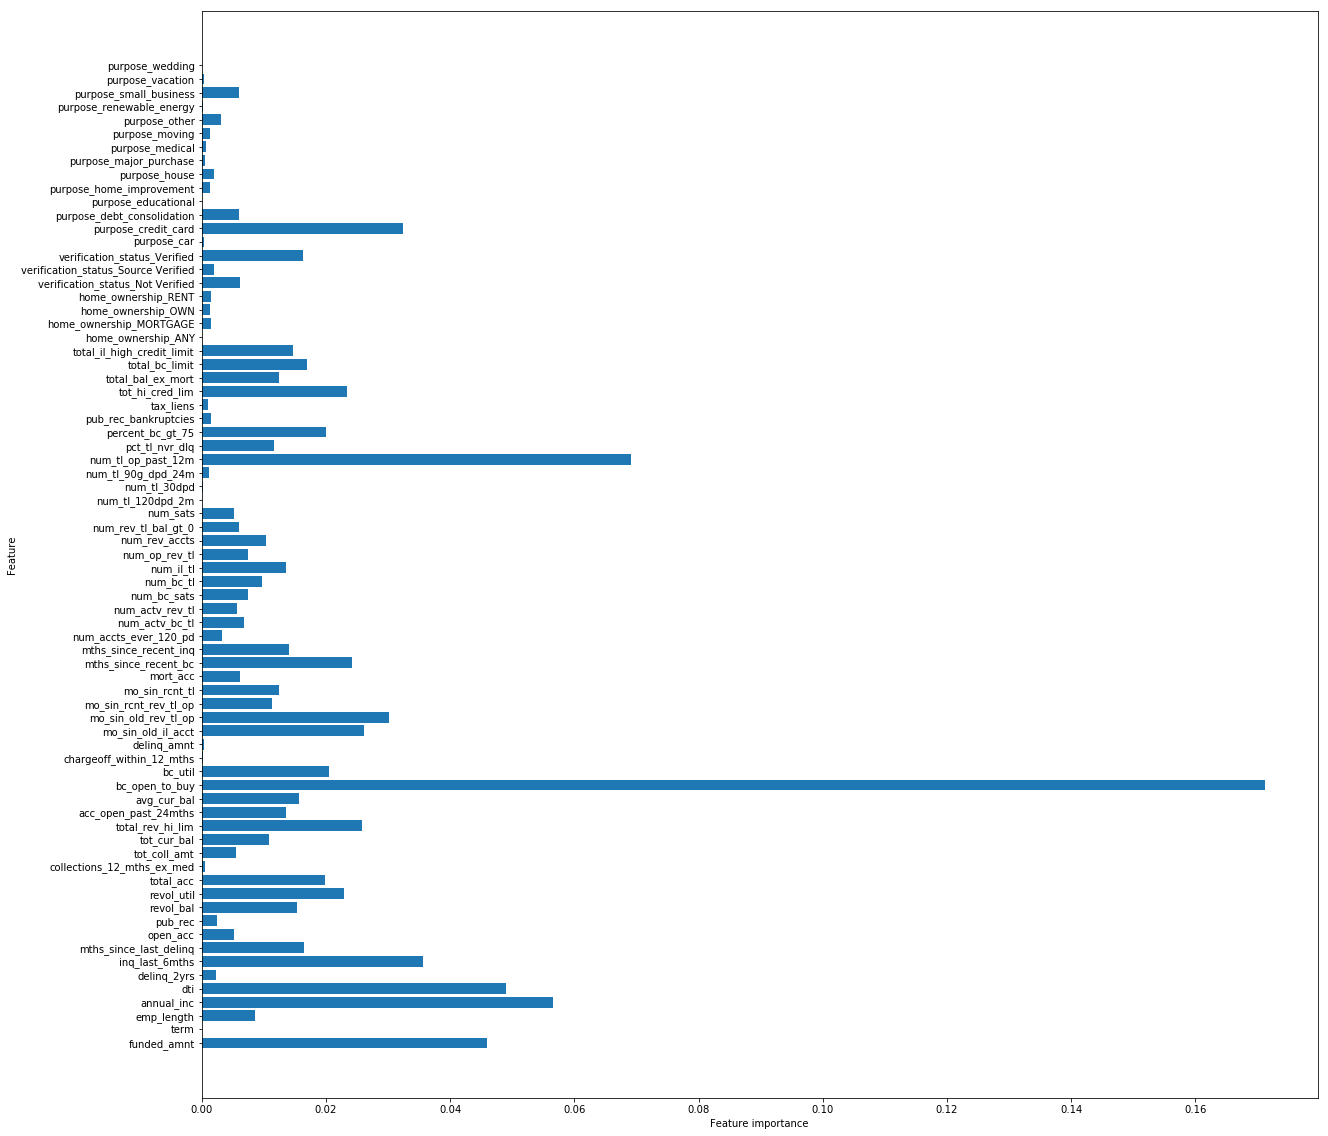

In [142]:
def plot_feature_importances (model):
    n_features = len(lc.columns.tolist()[1:])
    plt.figure(figsize=(20, 20))
    plt.barh(range(n_features), model.feature_importances_, align="center")
    plt.yticks(np.arange(n_features), lc.columns.tolist()[1:])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(rf_tt)

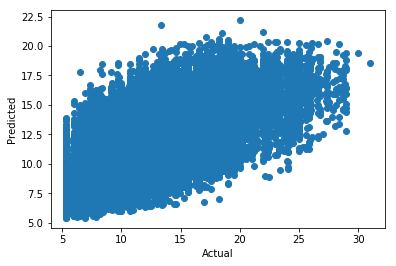

In [143]:
def plot_results_scatter (y_predict, y_test):
    plt.scatter(y_test, y_predict)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    
plot_results_scatter(rf_tt.predict(X_test), y_test)

In [144]:
rf_500est = RandomForestRegressor(n_estimators = 500, n_jobs = -1)
rf_500est.fit(X_train, y_train)
print("Training accuracy: {:.2f}".format(rf_500est.score(X_train, y_train)))
print("Generalization accuracy: {:.2f}".format(rf_500est.score(X_test, y_test)))

Training accuracy: 0.93
Generalization accuracy: 0.52


In [145]:
# try cross validating to see if the overfitting is a persistent issue

rf = RandomForestRegressor(n_estimators=100)
print("Cross-validation scores:\n{}".format(cross_val_score(rf, X, y, cv=5, n_jobs=-1)))

Cross-validation scores:
[ 0.46540889  0.49797476  0.53987845  0.51624898  0.47516886]


In [149]:
rf_lower_max_features = RandomForestRegressor(n_estimators = 100, max_features = 1, n_jobs = -1)
rf_lower_max_features.fit(X_train, y_train)
print("Training accuracy: {:.2f}".format(rf_lower_max_features.score(X_train, y_train)))
print("Generalization accuracy: {:.2f}".format(rf_lower_max_features.score(X_test, y_test)))

Training accuracy: 0.92
Generalization accuracy: 0.43


In [150]:
rf_higher_min_samples_leaf = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs = -1)
rf_higher_min_samples_leaf.fit(X_train, y_train)
print("Training accuracy: {:.2f}".format(rf_higher_min_samples_leaf.score(X_train, y_train)))
print("Generalization accuracy: {:.2f}".format(rf_higher_min_samples_leaf.score(X_test, y_test)))

Training accuracy: 0.73
Generalization accuracy: 0.51


In [152]:
rf_higher_min_samples_leaf1 = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 20, n_jobs = -1)
rf_higher_min_samples_leaf1.fit(X_train, y_train)
print("Training accuracy: {:.2f}".format(rf_higher_min_samples_leaf1.score(X_train, y_train)))
print("Generalization accuracy: {:.2f}".format(rf_higher_min_samples_leaf1.score(X_test, y_test)))

Training accuracy: 0.64
Generalization accuracy: 0.50


In [153]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [158]:
from sklearn.neural_network import MLPRegressor

initial_nn = MLPRegressor()
initial_nn.fit(X_train_scaled, y_train)
print("Training accuracy: {:.2f}".format(initial_nn.score(X_train_scaled, y_train)))
print("Generalization accuracy: {:.2f}".format(initial_nn.score(X_test_scaled, y_test)))

Training accuracy: 0.55
Generalization accuracy: 0.54
